In [1]:
%load_ext watermark
%watermark

Last updated: 2023-01-06T21:49:18.178367-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.7.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np

import pandas as pd

import cv2

from PIL import Image

import os

from io import BytesIO

import base64

import IPython
from IPython.display import HTML

from gtts import gTTS

from deep_translator import GoogleTranslator

import pytesseract

from progressbar import ProgressBar

from concurrent.futures import ThreadPoolExecutor

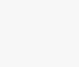

In [3]:
path = '_resources/img/blank.png'
# path = '_resources/img/Screenshot_20210528-100908.png'

img = Image.open(path)
img.thumbnail((300, 600))
img

In [4]:
def image_to_string(path):
    img = cv2.imread(path)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray, img_bin = cv2.threshold(gray, 128, 255,
                                  cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    gray = cv2.bitwise_not(img_bin)

    kernel = np.ones((2, 1), np.uint8)
    img = cv2.erode(gray, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)

    return pytesseract.image_to_string(img)


image_to_string(path)

''

''
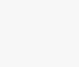

In [5]:
def b64encode(path):
    img = Image.open(path)
    img.thumbnail((600, 1000))

    with BytesIO() as buffer:
        img.save(buffer, 'png')
        img_encode = base64.b64encode(buffer.getvalue()).decode()

    return f'<img src="data:image/png;base64,{img_encode}">'


b64encode(path)

Se obtienen los textos a partir de las imágenes.

In [6]:
%%script echo Comentar para ejecutar la celda

raw_text_df = pd.DataFrame(columns=['name', 'image', 'text'])
raw_text_df.set_index(keys='name', inplace=True)

img_path = os.listdir('_resources/img')

bar = ProgressBar(maxval=len(img_path)).start()
i = 0


def gen_string(name):
    path = f'_resources/img/{name}'

    img = b64encode(path)
    text = image_to_string(path)

    name = name.split('.')[0]
    raw_text_df.loc[name] = [img, text]

    global i
    i += 1
    bar.update(i)


# max_workers=1 para que se ejecute en el mismo orden
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [executor.submit(gen_string, name)
               for name in img_path if name != 'desktop.ini']

bar.finish()

raw_text_df['status'] = False
raw_text_df.reset_index(inplace=True)
raw_text_df.head(10)

Couldn't find program: 'echo'


In [7]:
%%script echo Comentar para ejecutar la celda

raw_text_df.to_csv('_resources/raw_data.csv')

with open('_resources/raw_data.html', 'w') as file:
    html_string = raw_text_df.to_html(escape=False)
    file.write(html_string)
    del html_string

Couldn't find program: 'echo'


- Se debe hacer una copia del html guardado anteriormente (`raw_data.html`).
- Se debe editar el html copiado (`data.html`).

Se carga el html editado.

In [8]:
df = pd.read_html('_resources/data.html')[0][['name', 'text', 'status']]
# df.iloc[593].status = False  # Arreglar luego

df.head(10)

,name,text,status
0,Screenshot_20210528-100908,"Remember, you talk about two or more things. Y...",True
1,Screenshot_20210528-100918,You talk about things that happened and didn't...,True
2,Screenshot_20210528-100924,You talk about many things that happened in th...,True
3,Screenshot_20210528-101214,You talk about things that happened in the pas...,True
4,Screenshot_20210528-103610,You talk about the present. You talk about why...,True
5,Screenshot_20210528-103849,You talk about why things happened. You say: -...,True
6,Screenshot_20210528-104141,Good job! You know many sentences! You talk ab...,True
7,Screenshot_20210530-161202,"Remember: working, eating, watching, playing, ...",True
8,Screenshot_20210530-161416,You talk about the future. This is happening l...,True
9,Screenshot_20210530-161534,You ask questions about the future. I answer q...,True


Se actualizan los índices a formato xxxx para que los audios mantengan el orden necesario.

In [9]:
df.index = df.index.to_series().apply(lambda x: str(x).zfill(4))
df.head(10)

,name,text,status
0000,Screenshot_20210528-100908,"Remember, you talk about two or more things. Y...",True
0001,Screenshot_20210528-100918,You talk about things that happened and didn't...,True
0002,Screenshot_20210528-100924,You talk about many things that happened in th...,True
0003,Screenshot_20210528-101214,You talk about things that happened in the pas...,True
0004,Screenshot_20210528-103610,You talk about the present. You talk about why...,True
0005,Screenshot_20210528-103849,You talk about why things happened. You say: -...,True
0006,Screenshot_20210528-104141,Good job! You know many sentences! You talk ab...,True
0007,Screenshot_20210530-161202,"Remember: working, eating, watching, playing, ...",True
0008,Screenshot_20210530-161416,You talk about the future. This is happening l...,True
0009,Screenshot_20210530-161534,You ask questions about the future. I answer q...,True


Se generan los audios a partir de los textos.

In [10]:
bar = ProgressBar(maxval=df.shape[0]).start()
i = 0


def save_audio(row):
    path = f'_resources/audio/{row.name}.mp3'

    try:
        if row.status == False or os.path.exists(path) == True:
            raise ValueError()

        gtts = gTTS(text=row.text, lang='en', slow=True)
        gtts.save(path)
    except ValueError:
        pass
    except Exception as e:
        print(e)
        os.remove(path)
    finally:
        global i
        i += 1
        bar.update(i)


# max_workers=1 para que no nos de denegación de servicio
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [executor.submit(save_audio, row)
               for _, row in df.iterrows()]

    executor.shutdown(wait=True)

bar.finish()

100% |########################################################################|


Se traducen los textos a Español.

In [11]:
try:
    es_df = pd.read_csv('_resources/es.csv')
except:
    es_df = pd.DataFrame(index=df.index, columns=['es'])

es_df.index = es_df.index.to_series().apply(lambda x: str(x).zfill(4))
es_df.head(10)

,es
0000,"Recuerda, hablas de dos o más cosas. Tú dices:..."
0001,Hablas de cosas que sucedieron y no sucedieron...
0002,Hablas de muchas cosas que sucedieron en el pa...
0003,Hablas de cosas que sucedieron en el pasado. D...
0004,Hablas del presente. Hablas de por qué pasan l...
0005,Hablas de por qué sucedieron las cosas. Dices:...
0006,¡Buen trabajo! ¡Sabes muchas frases! Hablas de...
0007,"Recuerda: trabajar, comer, mirar, jugar, tomar..."
0008,Hablas del futuro. Esto está pasando más tarde...
0009,Haces preguntas sobre el futuro. Respondo preg...


In [12]:
translator = GoogleTranslator(source='en', target='es')

filter_df = df[df.status == True]

bar = ProgressBar(maxval=filter_df.shape[0]).start()
i = 0


def translate(row):
    try:
        if pd.isnull(es_df.loc[row.name].es) == False:
            raise ValueError()

        es_df.loc[row.name] = translator.translate(row.text)
    except ValueError:
        pass
    except Exception as e:
        print(e)
    finally:
        global i
        i += 1
        bar.update(i)

# max_workers=1 porque translator.translate no acepta multihilo y traduce texto que no se encuentra en su ámbito.
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [executor.submit(translate, row)
               for _, row in filter_df.iterrows()]

    executor.shutdown(wait=True)

bar.finish()

es_df.head(10)

100% |########################################################################|


,es
0000,"Recuerda, hablas de dos o más cosas. Tú dices:..."
0001,Hablas de cosas que sucedieron y no sucedieron...
0002,Hablas de muchas cosas que sucedieron en el pa...
0003,Hablas de cosas que sucedieron en el pasado. D...
0004,Hablas del presente. Hablas de por qué pasan l...
0005,Hablas de por qué sucedieron las cosas. Dices:...
0006,¡Buen trabajo! ¡Sabes muchas frases! Hablas de...
0007,"Recuerda: trabajar, comer, mirar, jugar, tomar..."
0008,Hablas del futuro. Esto está pasando más tarde...
0009,Haces preguntas sobre el futuro. Respondo preg...


In [13]:
es_df.to_csv(path_or_buf='_resources/es.csv', index=False)

Se construye la web final.

In [14]:
raw_text_df = pd.read_csv('_resources/raw_data.csv')
raw_text_df.head()

,Unnamed: 0,name,image,text,status
0,0,Screenshot_20210528-100908,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",vw 90%\nx Lesson ws\nGD 6/29\nInstructions:\nR...,False
1,1,Screenshot_20210528-100918,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",10:09 ™ @ 4s 90%\nx Lesson x\nGD 8/29\n\nInstr...,False
2,2,Screenshot_20210528-100924,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Pa @ 4A fho0%\nx Lesson ws\n\nD> 10/29\n\nInst...,False
3,3,Screenshot_20210528-101214,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Pd 90%\nx Lesson Ss\nD> 12/29\nInstructions:\n...,False
4,4,Screenshot_20210528-103610,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",vw 88%\nx Lesson ws\nGD 8/29\nInstructions:\nR...,False


In [15]:
raw_text_df.index = raw_text_df.index.to_series().apply(lambda x: str(x).zfill(4))

final_df = df.merge(right=raw_text_df, how='inner', left_index=True,
                    right_index=True, suffixes=('', '_y'), validate='1:1')
final_df = final_df[final_df.status == True][['name', 'image', 'text']]

final_df = final_df.merge(right=es_df, how='inner',
                          left_index=True, right_index=True)

final_df.head()

,name,image,text,es
0000,Screenshot_20210528-100908,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","Remember, you talk about two or more things. Y...","Recuerda, hablas de dos o más cosas. Tú dices:..."
0001,Screenshot_20210528-100918,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about things that happened and didn't...,Hablas de cosas que sucedieron y no sucedieron...
0002,Screenshot_20210528-100924,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about many things that happened in th...,Hablas de muchas cosas que sucedieron en el pa...
0003,Screenshot_20210528-101214,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about things that happened in the pas...,Hablas de cosas que sucedieron en el pasado. D...
0004,Screenshot_20210528-103610,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about the present. You talk about why...,Hablas del presente. Hablas de por qué pasan l...


In [16]:
IPython.display.Audio('_resources/audio/0000.mp3')

In [17]:
def make_audio(row):
    data = f'<audio controls><source src="audio/{row.name}.mp3" type="audio/mpeg">Not audio support.</audio>'
#     data = f'<audio controls><source src="_resources/audio/{row.name}.mp3" type="audio/mpeg">Not audio support.</audio>'
    return data

# Se puede agregar el audio pero la web no soporta más de 1000 WebMediaPlayer en una misma página.
# final_df['audio'] = final_df.apply(make_audio, axis=1)
final_df = final_df[['image', 'text', 'es']]
final_df.head()

,image,text,es
0000,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","Remember, you talk about two or more things. Y...","Recuerda, hablas de dos o más cosas. Tú dices:..."
0001,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about things that happened and didn't...,Hablas de cosas que sucedieron y no sucedieron...
0002,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about many things that happened in th...,Hablas de muchas cosas que sucedieron en el pa...
0003,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about things that happened in the pas...,Hablas de cosas que sucedieron en el pasado. D...
0004,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",You talk about the present. You talk about why...,Hablas del presente. Hablas de por qué pasan l...


In [18]:
final_df.to_csv('_resources/final_data.csv')

# Analizar los problemas luego.
es_error = ['0114', '0501', '0519', '0553', '0647', '0674', '0710', '0711', '1239', '1255', '1340', '1438', '1511', '1515', '1689']
display(final_df.iloc[es_error]['es'].values)
final_df.loc[es_error, ['es']] = ''

with open('_resources/final_data.html', 'w') as file:
    html_string = final_df.to_html(escape=False)
    file.write(html_string)
    del html_string

array(['¡Buen trabajo! Puedes hablar del pasado. Puedes usar palabras nuevas. - Acabamos de cenar en grande. Estábamos cansados \u200b\u200bdespués de la cena. - Ir de compras fue emocionante. Gracias. Te veo luego. - Acaba de terminar el trabajo. Fue largo. - La venta fue genial. Te veo pronto. - Acabo de hablar con mi hermano. El estaba bien.',
       'Puedes hablar de las cosas que tienes. A veces tienes más que tus amigos. A veces tienes menos que tus amigos. Dices: - Ella tiene más comida sana que yo. - Tiene menos videojuegos que Stephen. - Estás más emocionado que Susie. - Están menos cansados \u200b\u200bque nosotros.',
       'Puedes hablar de algo que sucedió muchas veces en el pasado, pero que no está sucediendo ahora. Puedes decir: solía. - Solía \u200b\u200besquiar todos los inviernos. - Solías bailar todos los fines de semana. - Solía \u200b\u200bmontar a caballo con sus amigos. - Solía \u200b\u200btener el pelo negro. - Solíamos caminar en ese bosque. - Solían tomar foto